## 公募基金业绩归因——基于前景理论的视角

$Yifan \space Zhang$ 

$2021.05$

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import *
from WindPy import w
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
pd.set_option('display.max_columns',None)

### Step 1：基金数据获取

需要获取的数据包括：
+ 普通股票型基金、混合型基金和灵活配置型基金的基本信息，包括基金代码、基金公司、基金类型等
+ 基金的每日净值
+ 基金的季度管理规模和持仓

In [2]:
start_date = '20070101'
end_date = '20200930'
update = False

In [3]:
if update:
    w.start()

In [4]:
# 数据获取函数

# 基金基础信息 从Wind终端下载原始表格
def GetFundsBasic():
        # 基金基础信息，包含Wind基金二级分类中的普通股票型、偏股混合型和灵活配置型基金
        funds_basic = pd.read_csv('funds_basic.csv', encoding='gbk')
        
        # 将C类基金去掉，基金规模采用A+C之和。选取至少成立1年的基金
        year_before_end = (pd.Timestamp(end_date)-pd.DateOffset(years=1)).strftime('%Y%m%d')
        funds_basic = funds_basic[(~funds_basic['name'].str.contains('C')) & (funds_basic['issue_date'] <= year_before_end)]
        
        return funds_basic


# 基金日度单位净值 调用Wind接口更新数据 
def GetFundsNav(fund_codes, start_date, end_date, update=False):
    funds_nav = pd.read_csv('funds_nav.csv', parse_dates=['date'])
    funds_nav = funds_nav[funds_nav['code'].isin(fund_codes)]
    funds_nav = funds_nav[(funds_nav['date'] >= start_date) & (funds_nav['date'] <= end_date)]
    load_end_date = np.max(funds_nav['date']).strftime('%Y%m%d')
    
    # 若需要更新数据
    if (end_date > load_end_date) & update & w.isconnected():
        start_date = (pd.Timestamp(load_end_date) + pd.DateOffset(days=1)).strftime('%Y%m%d')
        print('updating date from {} to {}'.format(start_date, end_date))
        
        # 限制单次获取数据量
        limit = 10
        new_funds_nav = []

        for i in trange(len(fund_codes)//10):
            if i < len(fund_codes)//10 - 1:
                codes = fund_codes[i*10: i*10+limit]
            else:
                codes = fund_codes[i*10:]
            
            _, nav = w.wsd(codes, "NAV_adj", start_date, end_date, usedf=True)
            new_funds_nav.append(nav)

        new_funds_nav = pd.concat(new_funds_nav, axis=1)
        new_funds_nav = new_funds_nav.stack().rename('nav').reset_index().rename(columns={'level_0':'date','level_1':'code'})
        funds_nav = pd.concat([funds_nav, new_funds_nav]).reset_index(drop=True)
        funds_nav = funds_nav.sort_values(by='date')
        funds_nav['date'] = funds_nav['date'].map(lambda x: x.strftime('%Y%m%d'))
        funds_nav.to_csv('funds_nav.csv', index=False)
        funds_nav = pd.read_csv('funds_nav.csv', parse_dates=['date'])
        
    return funds_nav


# 基金季度规模 调用Wind接口更新数据 
def GetFundsAsset(fund_codes, start_date, end_date, update=False):
    funds_asset = pd.read_csv('funds_asset.csv', parse_dates=['date'])
    funds_asset = funds_asset.dropna().reset_index(drop=True)
    funds_asset = funds_asset[funds_asset['code'].isin(fund_codes)]
    funds_asset = funds_asset[(funds_asset['date'] >= start_date) & (funds_asset['date'] <= end_date)]
    load_end_date = np.max(funds_asset['date']).strftime('%Y%m%d')
    
    # 若需要更新数据
    if (end_date > load_end_date) & update & w.isconnected():
        start_date = load_end_date
        print('updating from {} to {}'.format(start_date, end_date))
        _, new_funds_asset = w.wsd(fund_codes, "netasset_total", start_date, end_date, 'Period=Q;Days=Alldays',usedf=True)
        new_funds_asset = new_funds_asset.stack().rename('asset').reset_index().rename(columns={'level_0':'date','level_1':'code'})
        funds_asset = pd.concat([funds_asset, new_funds_asset]).reset_index(drop=True)
        funds_asset.drop_duplicates(subset=['date', 'code'], inplace=True)
        funds_asset = funds_asset.sort_values(by='date')
        funds_asset['date'] = funds_asset['date'].map(lambda x: x.strftime('%Y%m%d'))
        funds_asset.to_csv('funds_asset.csv', index=False)
        funds_asset = pd.read_csv('funds_asset.csv', parse_dates=['date'])
    
    return funds_asset
        
# 获取单一基金前X名重仓股的季度信息 调用Wind接口下载数据 
# 由于数据量较多 本研究采用从Wind终端下载excel再整合的形式获取持仓数据    
def GetFundPortfolio(fund_code, start_date, end_date, top=10):
    fund_portfolio = []
    
    # 遍历获取单一基金权重第X名的季度持仓信息
    for i in range(top):
        order = i + 1
        _, data = w.wsd(fund_code, 
                                  " fund_stm_issuingdate_qty, prt_topstockname, prt_topstockcode, prt_topproportiontofloating, prt_heavilyheldstocktostock", 
                                  start_date, end_date, 'Period=Q;Order={};Days=Alldays'.format(order),usedf=True)
        data.rename(columns={'FUND_STM_ISSUINGDATE_QTY':'rpt_date',
                                      'PRT_TOPSTOCKNAME':'stock_name',
                                      'PRT_TOPSTOCKCODE':'stock_code',
                                      'PRT_TOPPROPORTIONTOFLOATING':'floating_pct',
                                      'PRT_HEAVILYHELDSTOCKTOSTOCK':'holidng_pct'}, inplace=True)
        data['ranking'] = order
        data['code'] = fund_code
        fund_portfolio.append(data)
    fund_portfolio = pd.concat(fund_portfolio).dropna().reset_index().rename(columns={'index':'date'}) # 合并数据
    fund_portfolio = fund_portfolio.sort_values(by=['date','ranking']).reset_index(drop=True)          
    fund_portfolio = fund_portfolio[['code']+fund_portfolio.columns.tolist()[:-1]]                     
    return fund_portfolio

def GetFundsPortfolio(fund_basic, start_date, end_date):
    funds_info = fund_basic.set_index('code')['issue_date'].to_dict()
    funds_portfolio = []
    for fund_code, issue_date in tqdm(funds_info.items()):
        fund_portfolio = GetFundPortfolio(fund_code, max(start_date, issue_date), end_date)
        funds_portfolio.append(fund_portfolio)
    funds_portfolio = pd.concat(funds_portfolio).reset_index(drop=True)
    return funds_portfolio

In [5]:
# 基金基础信息，包含Wind基金二级分类中的普通股票型、偏股混合型和灵活配置型基金
funds_basic = GetFundsBasic()
funds_basic = funds_basic[funds_basic['type'].isin(['偏股混合型基金', '普通股票型基金'])]
fund_codes = funds_basic['code'].unique().tolist()
funds_basic.head()

,code,name,issue_date,type,management
0,000001.OF,华夏成长,2001-11-28,偏股混合型基金,华夏基金管理有限公司
1,000006.OF,西部利得量化成长,2019-02-15,偏股混合型基金,西部利得基金管理有限公司
2,000011.OF,华夏大盘精选,2004-07-06,偏股混合型基金,华夏基金管理有限公司
3,000017.OF,财通可持续发展主题,2013-02-25,偏股混合型基金,财通基金管理有限公司
4,000020.OF,景顺长城品质投资,2013-02-25,偏股混合型基金,景顺长城基金管理有限公司


In [6]:
# 基金每日净值和季度规模
funds_nav = GetFundsNav(fund_codes, start_date, end_date, update=update)
funds_asset = GetFundsAsset(fund_codes, start_date, end_date, update=update)

In [7]:
funds_asset.head(3)

,date,code,asset
0,2007-03-31,000001.OF,1.047223e+10
1,2007-03-31,121005.OF,1.577857e+09
2,2007-03-31,121003.OF,1.867102e+09


In [8]:
funds_nav.head(3)

,date,code,nav
0,2007-01-04,000001.OF,2.350666
1,2007-01-04,310328.OF,2.250894
2,2007-01-04,310358.OF,1.064700


In [9]:
funds_nav = funds_nav.sort_values(by=['code', 'date'])
funds_nav['ret'] = funds_nav.groupby('code')['nav'].pct_change().fillna(0).values

In [10]:
funds_nav

,date,code,nav,ret
0,2007-01-04,000001.OF,2.350666,0.000000
250,2007-01-05,000001.OF,2.346643,-0.001711
392,2007-01-08,000001.OF,2.389553,0.018286
519,2007-01-09,000001.OF,2.459282,0.029181
665,2007-01-10,000001.OF,2.486101,0.010905
...,...,...,...,...
3320392,2020-09-24,910007.OF,4.455900,-0.021799
3322960,2020-09-25,910007.OF,4.443500,-0.002783
3324885,2020-09-28,910007.OF,4.466400,0.005154
3327453,2020-09-29,910007.OF,4.488300,0.004903


### Step 2：基金数据统计

In [11]:
# 计算基金月度收益
def calRet(series):
    return np.nanprod(1 + series)-1

m_ret = funds_nav.groupby([pd.Grouper(key='date', freq='M'), 'code'])['ret'].apply(calRet)
m_ret.name = 'm_return'

In [ ]:
# 计算月度max收益
def calMax(series):
    return series.fillna(0).max()

m_max = funds_nav.groupby([pd.Grouper(key='date', freq='M'), 'code'])['ret'].apply(calMax)
m_max.name = 'm_max'

In [13]:
# 计算月度收益skewness
def calMax(series):
    return series.fillna(0).skew()

m_skew = funds_nav.groupby([pd.Grouper(key='date', freq='M'), 'code'])['ret'].apply(calMax)
m_skew.name = 'm_skew'

In [12]:
# 计算月度TK值
def calTK(series):
    alpha = 0.88
    lamb = 2.25
    gamma = 0.61
    delta = 0.69
    
    ret = series.fillna(0).sort_values()
    n = len(ret[ret > 0])
    m = len(ret[ret <= 0])
    ret = ret.map(lambda x: x**alpha if x > 0 else -lamb * (-x)**alpha)
    
    def calWeight(p, para):
        return p ** para / (p**para + (1 - p)**para) ** (1/para)
    
    if m > 0:
        w_n1 = pd.Series([i + 1 for i in range(m)]) / len(ret)
        w_n2 = pd.Series([i for i in range(m)]) / len(ret)
        w_n1 = w_n1.map(lambda x: calWeight(x, delta))
        w_n2 = w_n2.map(lambda x: calWeight(x, delta))
    
    if n > 0:
        w_p1 = pd.Series([m + i + 1 for i in range(n)]) / len(ret)
        w_p2 = pd.Series([m + i for i in range(n)]) / len(ret)
        w_p1 = w_p1.map(lambda x: calWeight(x, gamma))
        w_p2 = w_p2.map(lambda x: calWeight(x, gamma))
    
    if m == 0:
        w = w_p1 - w_p2
    elif n == 0:
        w = w_n1 - w_n2
    else:
        w = (w_n1 - w_n2).append(w_p1 - w_p2).values
    
#     print(ret.shape)
#     print(w.shape)
    return np.sum(ret * w)

m_tk = funds_nav.groupby([pd.Grouper(key='date', freq='M'), 'code'])['ret'].apply(calTK)
m_tk.name = 'm_tk'

In [47]:
funds_asset = funds_asset.sort_values(by=['code', 'date'])
funds_asset['netflow'] = funds_asset.groupby(['code']).apply(lambda df: df['asset'].diff()).values
funds_asset['netflow'] = funds_asset['netflow'].fillna(0)

In [98]:
month_data = pd.merge(left=m_stat, right=funds_asset, on=['date', 'code'], how='left')
month_data = pd.merge(left = month_data, right= funds_basic[['code', 'name', 'issue_date', 'type']], on = 'code', how='left')

In [99]:
month_data = month_data.sort_values(by=['code', 'date'])
month_data['is_quarter'] = ~month_data['asset'].isna()
month_data['issue_date'] = month_data['issue_date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
month_data['age'] = (month_data['date'] - month_data['issue_date']).map(lambda x: x.days)
month_data['asset'] = month_data.groupby(['code'])['asset'].fillna(method='ffill').values
month_data['netflow'] = month_data.groupby(['code'])['netflow'].fillna(method='ffill').values

Text(0, 0.5, '基金数')

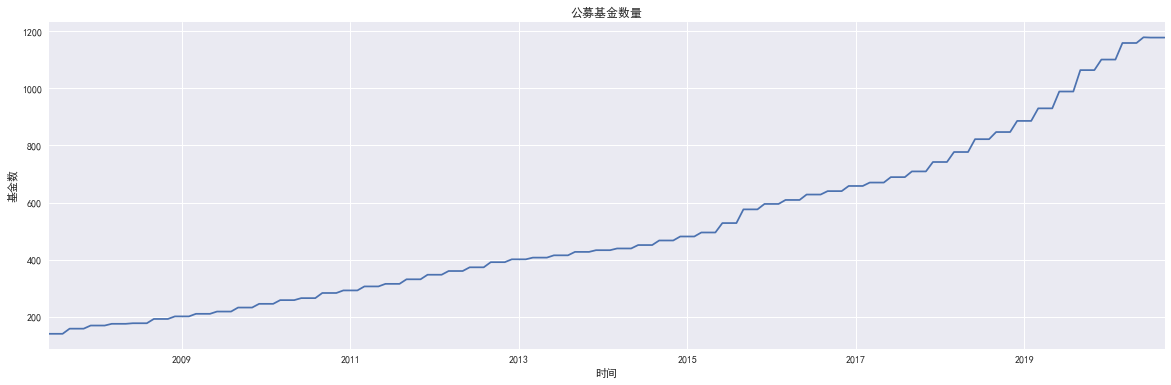

In [28]:
# 优选基金池dict：key-Timestamp; value-fund codes list
funds_dict = month_data.groupby('date')['code'].apply(lambda x: x.tolist()).to_dict()
funds_count = month_data.groupby('date')['code'].apply(lambda x: x.count())
plot = funds_count.plot(title='公募基金数量', figsize=(20, 6))

### Step 3：基金季度重仓股票池

In [172]:
# 读取wind终端下载的基金持仓数据
def GetPortfolios(start_date, end_date, update=False):
    portfolios = pd.read_csv('funds_portfolio.csv', parse_dates=['date'])
    portfolios = portfolios[(portfolios['date'] >= start_date) & (portfolios['date'] <= end_date)]
    load_end_date = np.max(portfolios['date']).strftime('%Y%m%d')
    
    if (load_end_date < end_date) & update:
        # 需要有从wind终端下载的原始数据
        assert os.path.exists('portfolio'), 'portfolio file not exists'
        portfolio_files = os.listdir('portfolio')
        portfolios = []
        for file in tqdm(portfolio_files):
            portfolio = pd.read_excel('./portfolio/{}'.format(file))
            portfolio.dropna(subset=['股票代码'], inplace=True)
            portfolios.append(portfolio)
        portfolios = pd.concat(portfolios)
        portfolios.columns=['code', 'name', 'date', 'stock_code', 'stock_name', 'hold_amt', 'hold_amt_chg', 'hold_to_float', 'hold_mkv',
                            'hold_to_nav', 'hold_pct', 'type', 'manager']
        portfolios = portfolios.drop('hold_to_nav', axis=1)
        portfolios = portfolios[portfolios['type'].isin(['偏股混合型基金', '灵活配置型基金', '普通股票型基金'])]

        rpt_date = list(portfolios['date'].unique())
        date = list(pd.date_range('20030101', '20200930', freq='Q'))
        date = list(map(lambda x:x.strftime('%Y-%m-%d'), date))

        # 修改date为日期格式
        portfolios['date'] = portfolios['date'].replace(rpt_date, date)

        # 将hold_amt_chg的nan值填充为hold_amt(上一个季度若没有持仓，则该季度持仓变化为总持仓数)
        portfolios.loc[portfolios['hold_amt_chg'].isna(), 'hold_amt_chg'] = portfolios.loc[portfolios['hold_amt_chg'].isna(), 'hold_amt']
        portfolios.to_csv('funds_portfolio.csv', index=False)

    return portfolios

In [173]:
portfolios = GetPortfolios(start_date, end_date, update=update)

In [174]:
# 获取基金的持仓信息
portfolios = portfolios[portfolios['date'].isin(funds_dict.keys())]
def SelectFunds(df):
    date = df['date'].iloc[0]
    return df[df['code'].isin(funds_dict[date])]
portfolios = portfolios.groupby('date').apply(SelectFunds).reset_index(drop=True)

基金持仓信息

In [175]:
portfolios.head()

,code,name,date,stock_code,stock_name,hold_amt,hold_amt_chg,hold_to_float,hold_mkv,hold_pct,type,manager
0,000001.OF,华夏成长,2007-03-31,600005.SH,武钢股份(退市),8191.2241,6991.3009,2.888314,74376.314828,9.199276,偏股混合型基金,华夏基金管理有限公司
1,000001.OF,华夏成长,2007-03-31,600177.SH,雅戈尔,2827.4418,2827.4418,3.118670,44079.817662,5.452037,偏股混合型基金,华夏基金管理有限公司
2,000001.OF,华夏成长,2007-03-31,600036.SH,招商银行,2479.9864,1924.4841,0.526560,43102.163632,5.331115,偏股混合型基金,华夏基金管理有限公司
3,000001.OF,华夏成长,2007-03-31,000568.SZ,泸州老窖,1565.5365,891.0735,4.174760,42582.592800,5.266852,偏股混合型基金,华夏基金管理有限公司
4,000001.OF,华夏成长,2007-03-31,002024.SZ,苏宁易购,625.2987,415.4139,2.125437,40019.116800,4.949787,偏股混合型基金,华夏基金管理有限公司


股票日收益

In [24]:
stock_return = pd.read_csv('stock_return.csv', index_col=False)
stock_return.iloc[:, 1:] = stock_return.iloc[:, 1:] / 100

In [25]:
stock_return['date'] = stock_return['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [26]:
stock_return.head()

,date,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,688588.SH,688589.SH,688595.SH,688596.SH,688598.SH,688599.SH,688600.SH,688788.SH,688981.SH,689009.SH
0,2007-01-04,-0.024879,0.002591,-0.009756,-0.008032,0.021626,-0.024793,-0.002398,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-05,-0.074415,-0.040698,-0.007389,0.016194,0.027007,0.029661,0.016827,-0.004728,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-01-08,0.023737,0.029630,0.029777,0.031873,0.030561,0.045267,0.028369,0.019002,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-01-09,0.032162,0.020275,0.021687,0.027027,0.024138,0.011811,0.006897,0.048951,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,0.020290,0.100000,-0.007075,0.048872,0.011448,0.015564,0.100457,0.020000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
stock_return_q = stock_return.groupby(pd.Grouper(key='date', freq='Q')).sum()

In [28]:
stock_return_q.head()

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,688588.SH,688589.SH,688595.SH,688596.SH,688598.SH,688599.SH,688600.SH,688788.SH,688981.SH,689009.SH
date,,,,,,,,,,,,,,,,,,,,,
2007-03-31,0.302724,0.129263,0.645460,0.896720,0.099808,0.777218,0.583902,0.600902,0.506806,0.445156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-06-30,0.521861,0.604463,-0.105692,0.419339,0.645563,-0.023065,-0.080337,0.477041,0.033332,0.369822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-09-30,0.410911,0.500051,0.429494,-0.089106,0.397589,0.515243,0.622120,0.256343,0.573458,0.226663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-31,-0.003310,-0.009222,0.082366,-0.079803,-0.267482,0.040420,0.100311,0.120318,0.050000,-0.113779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-03-31,-0.264393,-0.073640,-0.173732,-0.012890,-0.022394,0.056566,-0.363931,-0.084191,0.000000,-0.404907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


基金日收益

In [12]:
funds_nav.head()

,date,code,nav,ret
0,2007-01-04,000001.OF,2.350666,0.000000
250,2007-01-05,000001.OF,2.346643,-0.001711
392,2007-01-08,000001.OF,2.389553,0.018286
519,2007-01-09,000001.OF,2.459282,0.029181
665,2007-01-10,000001.OF,2.486101,0.010905


风格因子日收益

In [13]:
factor = pd.read_csv('factor.csv', index_col=False)
factor['date'] = factor['date'].map(lambda x: datetime.strptime(x, '%Y/%m/%d'))
factor.head()

,date,RF,MKT,SMB,HML,RMW,CMA,UMD
0,2007-01-04,0.000077,0.020778,-0.035973,0.027372,0.038737,-0.001790,-0.019456
1,2007-01-05,0.000077,0.011173,0.020113,0.038612,-0.030202,0.037008,-0.034437
2,2007-01-08,0.000077,0.031422,0.018075,0.016250,-0.011818,0.005643,-0.001835
3,2007-01-09,0.000077,0.039326,-0.032928,-0.005987,0.039366,-0.014608,0.015575
4,2007-01-10,0.000077,0.019432,0.006386,-0.003908,-0.020784,-0.007160,0.013789


In [161]:
quarter_data = month_data[month_data['is_quarter']]
quarter_data.head()

,date,code,m_return,m_max,m_skew,m_tk,asset,netflow,name,issue_date,type,is_quarter,age,capm_alpha,ff3_alpha,carh_alpha,ff5_alpha,ff6_alpha
2,2007-03-31,000001.OF,0.053783,0.024839,-0.380912,0.013506,1.047223e+10,0.000000e+00,华夏成长,2001-11-28,偏股混合型基金,True,1949,-0.025744,-0.014075,-0.011454,-0.012186,-0.009018
5,2007-06-30,000001.OF,0.005025,0.026667,-0.647548,0.016439,1.081736e+10,1.150427e+08,华夏成长,2001-11-28,偏股混合型基金,True,2040,0.064263,0.048387,0.051629,0.032833,0.035524
8,2007-09-30,000001.OF,0.038749,0.021111,-0.372705,0.012460,1.369451e+10,9.590519e+08,华夏成长,2001-11-28,偏股混合型基金,True,2132,-0.013221,-0.004103,-0.007390,-0.005015,-0.008523
11,2007-12-31,000001.OF,0.130812,0.023472,-1.362972,0.017003,1.276897e+10,-3.085155e+08,华夏成长,2001-11-28,偏股混合型基金,True,2224,0.033314,0.030919,0.034400,0.034386,0.038873
14,2008-03-31,000001.OF,-0.117391,0.029703,0.235650,0.013224,1.084086e+10,-6.427030e+08,华夏成长,2001-11-28,偏股混合型基金,True,2315,0.018635,0.016537,0.018277,0.023956,0.025698


In [163]:
daily_dates = list(funds_nav['date'].unique())
quarterly_dates = list(quarter_data['date'].unique())

def getLastQuarterEnd(end_date):
    if end_date == quarterly_dates[0]:
        return end_date
    else:
        q_index = quarterly_dates.index(end_date)
        last_date = quarterly_dates[q_index - 1]
    return last_date
    
def getQuarterStart(end_date):
    if end_date == quarterly_dates[0]:
        return daily_dates[0]
    else:
        q_index = quarterly_dates.index(end_date)
        last_q = quarterly_dates[q_index - 1]
        return np.array(daily_dates)[daily_dates > last_q][0]
    
def getNexrQuarterRet(codes, end_date):
    q_index = quarterly_dates.index(end_date)
    next_q = quarterly_dates[q_index + 1]
    return stock_return_q.loc[next_q, codes]

In [34]:
stock_list = stock_return.columns.tolist()

In [36]:
q_dict = {
    'code':[],
    'date':[],
    'next_port_return':[],
    'q_return':[],
}

for key, df in tqdm(quarter_data.groupby(['code', 'date'])):
    code = key[0]
    end_date = key[1]
    start_date = getQuarterStart(end_date)
    
    if end_date == quarterly_dates[-1]:  # 2020-09-30不用算
        continue
        
    next_portfolio = portfolios.loc[(portfolios['code'] == code) & (portfolios['date'] == end_date), 'stock_code'].values  # 下一期的持仓
    next_portfolio = [code for code in next_portfolio if code in stock_list]
    next_weight = portfolios.loc[(portfolios['code'] == code) & (portfolios['date'] == end_date) 
                                 & (portfolios['stock_code'].isin(next_portfolio)), 'hold_pct'].values 
    next_weight = next_weight / np.sum(next_weight)
    next_stock_return = getNexrQuarterRet(next_portfolio, end_date)
    
    # 持仓下一季度的return
    next_port_return = np.sum(np.dot(next_weight, next_stock_return)) 
    
    # regression : fund_nav ~ facs + alpha
    fund_ret = funds_nav.loc[(funds_nav['code'] == code) & (funds_nav['date'] >= start_date) & 
                             (funds_nav['date'] <= end_date), 'ret']
    
    q_dict['code'].append(code)
    q_dict['date'].append(end_date)
    q_dict['next_port_return'].append(next_port_return)
    q_dict['q_return'].append(np.prod(1 + fund_ret) - 1)

100%|██████████████████████████████████████████████████████████████████████████| 29209/29209 [1:27:15<00:00,  5.58it/s]


In [38]:
q_data = pd.DataFrame(q_dict)

In [45]:
q_data['port_return'] = q_data.groupby(['code'])['next_port_return'].shift()

In [18]:
def factorRegression(fund_ret, fac):
    capm = fac[['MKT']]
    capm = sm.add_constant(capm)
    model = sm.OLS(fund_ret.values, capm.values)
    results = model.fit()
    capm_alpha = results.resid
    
    ff3 = fac[['MKT','SMB', 'HML']]
    ff3 = sm.add_constant(ff3)
    model = sm.OLS(fund_ret.values, ff3.values)
    results = model.fit()
    ff3_alpha = results.resid
    
    carh = fac[['MKT','SMB', 'HML', 'UMD']]
    carh = sm.add_constant(carh)
    model = sm.OLS(fund_ret.values, carh.values)
    results = model.fit()
    carh_alpha = results.resid
    
    ff5 = fac[['MKT','SMB', 'HML', 'RMW', 'CMA']]
    ff5 = sm.add_constant(ff5)
    model = sm.OLS(fund_ret.values, ff5.values)
    results = model.fit()
    ff5_alpha = results.resid
    
    ff6 = fac[['MKT','SMB', 'HML', 'RMW', 'CMA', 'UMD']]
    ff6 = sm.add_constant(ff6)
    model = sm.OLS(fund_ret.values, ff6.values)
    results = model.fit()
    ff6_alpha = results.resid
    
    return capm_alpha, ff3_alpha, carh_alpha, ff5_alpha, ff6_alpha

In [20]:
dfs = []
for code, df in tqdm(funds_nav.groupby('code')):
    data = df.copy()
    ret = data['ret']
    dates = data['date'].values
    fac = factor.loc[factor['date'].isin(dates)]
    capm_alpha, ff3_alpha, carh_alpha, ff5_alpha, ff6_alpha = factorRegression(ret, fac)
    data['capm_alpha'] = capm_alpha
    data['ff3_alpha'] = ff3_alpha
    data['carh_alpha'] = carh_alpha
    data['ff5_alpha'] = ff5_alpha
    data['ff6_alpha'] = ff6_alpha
    dfs.append(data)

100%|██████████████████████████████████████████████████████████████████████████████| 1179/1179 [01:18<00:00, 14.95it/s]


In [26]:
funds_nav = pd.concat(dfs)

In [27]:
funds_nav.head()

,date,code,nav,ret,capm_alpha,ff3_alpha,carh_alpha,ff5_alpha,ff6_alpha
0,2007-01-04,000001.OF,2.350666,0.000000,-0.014971,-0.008500,-0.007484,-0.009433,-0.008251
250,2007-01-05,000001.OF,2.346643,-0.001711,-0.009829,-0.003238,-0.002169,-0.000665,0.000677
392,2007-01-08,000001.OF,2.389553,0.018286,-0.004279,-0.001235,-0.001725,-0.001402,-0.001928
519,2007-01-09,000001.OF,2.459282,0.029181,0.000977,0.001721,0.001264,0.000284,-0.000158
665,2007-01-10,000001.OF,2.486101,0.010905,-0.003106,-0.003612,-0.004477,-0.002692,-0.003815


In [37]:
# 计算Monthly alphas
alphas = ['capm_alpha', 'ff3_alpha', 'carh_alpha', 'ff5_alpha', 'ff6_alpha']
for alpha in tqdm(alphas):   
    month_data[alpha] = funds_nav.groupby(['code', pd.Grouper(key='date', freq='M')])[alpha].sum().values

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


In [180]:
# 计算turnover rate
codes = list(q_data['code'])
dates = list(q_data['date'])

turnover_rate = []
for i in trange(len(codes)):
    code = codes[i]
    date = dates[i] 
    last_date = getLastQuarterEnd(date)
        
    next_portfolio = portfolios.loc[(portfolios['code'] == code) & (portfolios['date'] == date), 'stock_code'].values  
    portfolio = portfolios.loc[(portfolios['code'] == code) & (portfolios['date'] == last_date), 'stock_code'].values 
    if len(next_portfolio) == 0:
        rate = 1
    else:
        rate = len(set(next_portfolio).difference(set(portfolio))) / len(next_portfolio)
    turnover_rate.append(rate)

q_data['turnover_rate'] = turnover_rate

100%|████████████████████████████████████████████████████████████████████████████| 28031/28031 [38:48<00:00, 12.04it/s]


In [29]:
month_data = month_data.drop(columns=['asset', 'netflow'])
month_data = pd.merge(left=month_data, right=q_data, on=['code', 'date'], how='left')
month_data['q_return'] = month_data.groupby(['code'])['q_return'].fillna(method='ffill').values
month_data['port_return'] = month_data.groupby(['code'])['port_return'].fillna(method='ffill').values
month_data['next_port_return'] = month_data.groupby(['code'])['next_port_return'].fillna(method='ffill').values
month_data['asset'] = month_data.groupby(['code'])['asset'].fillna(method='ffill').values
month_data['netflow'] = month_data.groupby(['code'])['netflow'].fillna(method='ffill').values
month_data['turnover_rate'] = month_data.groupby(['code'])['turnover_rate'].fillna(method='ffill').values
month_data['year'] = month_data['date'].map(lambda x: x.year)

读取处理好的数据

In [20]:
month_data = pd.read_csv('month_data.csv', index_col=False)
month_data['date'] = pd.to_datetime(month_data['date'])

In [21]:
month_data.head()

,date,code,m_return,m_max,m_skew,m_tk,name,issue_date,type,is_quarter,age,capm_alpha,ff3_alpha,carh_alpha,ff5_alpha,ff6_alpha,next_port_return,q_return,port_return,asset,netflow,turnover_rate,year,last_m_tk
0,2007-01-31,000001.OF,0.103576,0.076609,0.499875,0.001376,华夏成长,2001-11-28,偏股混合型基金,False,1890,-0.022778,-0.012730,-0.013734,-0.008415,-0.009520,NaN,NaN,NaN,NaN,NaN,NaN,2007,NaN
1,2007-02-28,000001.OF,0.036862,0.033333,-2.016698,0.004273,华夏成长,2001-11-28,偏股混合型基金,False,1918,-0.023679,0.008752,0.012812,0.018044,0.022582,NaN,NaN,NaN,NaN,NaN,NaN,2007,0.029880
2,2007-03-31,000001.OF,0.053783,0.024839,-0.380912,-0.010936,华夏成长,2001-11-28,偏股混合型基金,True,1949,-0.025744,-0.014075,-0.011454,-0.012186,-0.009018,0.464598,0.205797,NaN,1.047223e+10,0.0,0.0,2007,0.019242
3,2007-04-30,000001.OF,0.226644,0.036513,-1.110781,-0.000855,华夏成长,2001-11-28,偏股混合型基金,False,1979,0.024215,0.043809,0.040509,0.051486,0.048422,0.464598,0.205797,NaN,1.047223e+10,0.0,0.0,2007,0.013506
4,2007-05-31,000001.OF,0.122708,0.026093,-1.709229,-0.006096,华夏成长,2001-11-28,偏股混合型基金,False,2010,0.030278,0.035691,0.036535,0.031080,0.031816,0.464598,0.205797,NaN,1.047223e+10,0.0,0.0,2007,0.024126


### 数据分析

1. 数据基本统计量

In [22]:
month_data = month_data.dropna()

In [23]:
month_data = month_data.replace([np.inf, -np.inf], 0)

In [24]:
month_data['age'] = np.log(month_data['age'] + 1)
month_data['asset'] = np.log(month_data['asset'] + 1)
month_data['netflow'] = np.log(np.abs(month_data['netflow']) + 1) * np.sign(month_data['netflow'])

In [29]:
month_data.groupby('year').mean()

,m_return,m_max,m_skew,m_tk,is_quarter,age,capm_alpha,ff3_alpha,carh_alpha,ff5_alpha,ff6_alpha,next_port_return,q_return,port_return,asset,netflow,turnover_rate,last_m_tk
year,,,,,,,,,,,,,,,,,,
2007,0.048503,0.031556,-0.490601,-0.006609,0.439323,6.394296,0.006228,0.011038,0.012014,0.009370,0.010138,0.087696,0.305845,0.258270,22.611672,10.151952,0.581750,0.017766
2008,-0.052088,0.042260,0.193982,-0.006259,0.343160,6.649589,0.005023,0.006863,0.006408,0.005792,0.005054,-0.149195,-0.146655,-0.171906,22.393982,-17.649904,0.489943,0.016940
2009,0.047830,0.033080,-0.217747,-0.006308,0.344499,6.849969,-0.004078,0.005798,0.006920,0.003982,0.005076,0.120348,0.100815,0.096262,21.924047,2.465715,0.584279,0.016847
2010,0.005048,0.023868,-0.254398,-0.006385,0.343125,6.952973,0.006094,-0.002164,-0.003194,-0.002405,-0.003400,0.015794,0.034193,0.025547,21.754180,-1.861878,0.556727,0.012315
2011,-0.022843,0.019823,-0.181592,-0.006406,0.343016,7.057958,-0.010266,-0.006812,-0.006312,-0.006138,-0.005464,-0.062096,-0.046558,-0.041509,21.448528,-12.746417,0.524505,0.009936
2012,0.005858,0.022316,0.236283,-0.006817,0.341392,7.132676,-0.004034,-0.002450,-0.002387,-0.002351,-0.002336,0.023102,-0.006528,0.001726,20.956205,-6.734012,0.503056,0.010293
2013,0.013349,0.025004,-0.106800,-0.006789,0.337615,7.271362,0.006846,0.002246,0.000512,0.001893,0.000019,0.024971,0.051994,0.044892,20.710295,-1.693480,0.546530,0.013544
2014,0.019296,0.020485,-0.375230,-0.007118,0.339240,7.394609,-0.018982,-0.005910,-0.005087,-0.005062,-0.004175,0.061719,0.037372,0.024063,20.551542,-5.204737,0.547123,0.010393
2015,0.038168,0.044268,-0.368188,-0.007113,0.345294,7.340361,0.013180,0.005934,0.006977,0.004143,0.005108,0.069300,0.089805,0.065390,20.532392,-4.411456,0.664605,0.023039


In [30]:
month_data.groupby('year')['code'].nunique()

year
2007     169
2008     201
2009     245
2010     292
2011     347
2012     401
2013     433
2014     481
2015     595
2016     658
2017     742
2018     886
2019    1101
2020    1179
Name: code, dtype: int64

In [34]:
month_data.describe()

,m_return,m_max,m_skew,m_tk,age,capm_alpha,ff3_alpha,carh_alpha,ff5_alpha,ff6_alpha,next_port_return,q_return,port_return,asset,netflow,turnover_rate,year,last_m_tk
count,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000,81732.000000
mean,0.012787,0.026872,-0.136078,-0.007007,7.266287,0.000484,0.000200,0.000208,0.000193,0.000201,0.034013,0.040540,0.033420,20.443545,-3.658154,0.553505,2015.648228,0.013475
std,0.073690,0.012739,0.690501,0.010479,0.887625,0.039294,0.030955,0.030761,0.030217,0.029970,0.145113,0.142948,0.148242,1.655710,17.973630,0.275045,3.528595,0.005985
min,-0.362046,-0.000720,-4.795832,-0.073683,4.521789,-0.317037,-0.245456,-0.232274,-0.225970,-0.216235,-0.551124,-0.421442,-0.551124,12.367508,-23.508863,0.000000,2007.000000,-0.003564
25%,-0.026937,0.017807,-0.507275,-0.011805,6.664409,-0.019930,-0.017509,-0.017228,-0.017080,-0.016791,-0.046377,-0.048672,-0.046896,19.244234,-18.792881,0.300000,2013.000000,0.009248
50%,0.012457,0.024397,-0.092802,-0.005183,7.417881,-0.000327,-0.000945,-0.001170,-0.000948,-0.001059,0.014622,0.019587,0.006140,20.661869,-16.360556,0.500000,2016.000000,0.012429
75%,0.050894,0.033389,0.299902,-0.000523,7.984122,0.020232,0.016546,0.016172,0.016197,0.015798,0.110630,0.112074,0.107125,21.686309,17.714336,0.800000,2019.000000,0.016537
max,0.455366,0.158935,4.687433,0.037339,8.846785,0.305863,0.245698,0.250881,0.248004,0.251697,0.756010,0.878007,0.756010,24.598086,24.191152,1.000000,2020.000000,0.047936


In [35]:
month_data.corr()

,m_return,m_max,m_skew,m_tk,is_quarter,age,capm_alpha,ff3_alpha,carh_alpha,ff5_alpha,ff6_alpha,next_port_return,q_return,port_return,asset,netflow,turnover_rate,year,last_m_tk
m_return,1.000000,0.076333,0.000563,-0.005125,-0.003103,0.008677,0.580029,0.473275,0.487032,0.463563,0.478507,0.422032,0.134168,0.091527,-0.044241,0.101810,-0.001662,0.091957,0.040377
m_max,0.076333,1.000000,0.187908,0.017227,-0.028086,-0.032950,0.143723,0.167640,0.176936,0.149447,0.158097,0.009505,0.074595,0.054478,0.034398,0.022583,0.020866,-0.034503,0.581922
m_skew,0.000563,0.187908,1.000000,-0.004316,-0.016753,-0.001124,-0.012702,0.016835,0.011579,0.010105,0.006250,0.013441,-0.149933,-0.122700,-0.019798,-0.080048,-0.035623,0.028625,-0.056741
m_tk,-0.005125,0.017227,-0.004316,1.000000,0.000947,0.014253,0.001312,0.002508,0.002525,0.002328,0.002394,-0.004800,-0.006447,-0.004491,0.031328,-0.005030,0.004084,-0.024426,0.018010
is_quarter,-0.003103,-0.028086,-0.016753,0.000947,1.000000,-0.023141,-0.012483,-0.014950,-0.015086,-0.040922,-0.039659,0.009061,0.029510,0.025943,-0.007098,0.015582,-0.005120,-0.006916,0.026129
age,0.008677,-0.032950,-0.001124,0.014253,-0.023141,1.000000,0.043098,-0.016114,-0.016816,-0.007985,-0.008484,0.012758,0.007175,0.019151,0.239394,0.101508,-0.151646,0.176396,-0.007942
capm_alpha,0.580029,0.143723,-0.012702,0.001312,-0.012483,0.043098,1.000000,0.807684,0.801090,0.788013,0.781018,0.229346,0.090776,0.059319,-0.020188,0.079082,-0.014640,0.064310,0.072112
ff3_alpha,0.473275,0.167640,0.016835,0.002508,-0.014950,-0.016114,0.807684,1.000000,0.986472,0.979642,0.965233,0.166562,0.107043,0.070241,-0.024380,0.075003,0.011414,-0.002646,0.041447
carh_alpha,0.487032,0.176936,0.011579,0.002525,-0.015086,-0.016816,0.801090,0.986472,1.000000,0.965968,0.978900,0.174592,0.111347,0.070095,-0.023254,0.076725,0.012248,-0.003352,0.044966
ff5_alpha,0.463563,0.149447,0.010105,0.002328,-0.040922,-0.007985,0.788013,0.979642,0.965968,1.000000,0.985162,0.157142,0.116436,0.078408,-0.025599,0.081980,0.008015,0.007712,0.031007


2. 按TK值分组统计 & 累计收益

In [36]:
def getTKtable(month_data, win=1):
    data = month_data.copy()
    if win == 1:
        tk_col = 'm_tk'
    else:
        tk_col = 'm{}_tk'.format(win)
        data[tk_col] = month_data.groupby('code')['m_tk'].rolling(win).mean().values
    
    # 按给定指标分组 在固定日期后分组
    label_name = [str(i+1) for i in range(5)]
    data = data.dropna(subset=[tk_col])
    print('样本数量：{}'.format(len(data)))
    group = data.groupby(['date'])[tk_col].apply(lambda s: pd.qcut(s, len(label_name), labels=label_name)).values
    data['group'] = group

    # 计算分组收益均值
    stat_col = ['m_return', 'capm_alpha', 'ff3_alpha', 'carh_alpha', 'ff5_alpha', 'ff6_alpha']
    groups = []
    for col in stat_col:
        group = data.groupby('group')[col].mean()
        group.name = col
        group.index.name = 'group'
        groups.append(group)

    groups = pd.concat(groups, axis=1).T
    return groups, data

In [40]:
groups, data = getTKtable(month_data)
groups

样本数量：81732


group,1,2,3,4,5
m_return,0.012771,0.012832,0.012781,0.012806,0.012747
capm_alpha,0.000304,0.000137,0.000458,0.000529,0.000990
ff3_alpha,-0.000041,-0.000021,0.000401,0.000221,0.000439
carh_alpha,-0.000007,0.000014,0.000400,0.000200,0.000436
ff5_alpha,-0.000064,-0.000025,0.000367,0.000253,0.000435
ff6_alpha,-0.000038,0.000010,0.000371,0.000238,0.000425


In [41]:
groups.columns = ['1', '2', '3', '4', '5']
groups['5-1'] = groups['5'] - groups['1']
groups

,1,2,3,4,5,5-1
m_return,0.012771,0.012832,0.012781,0.012806,0.012747,-0.000024
capm_alpha,0.000304,0.000137,0.000458,0.000529,0.000990,0.000687
ff3_alpha,-0.000041,-0.000021,0.000401,0.000221,0.000439,0.000480
carh_alpha,-0.000007,0.000014,0.000400,0.000200,0.000436,0.000442
ff5_alpha,-0.000064,-0.000025,0.000367,0.000253,0.000435,0.000499
ff6_alpha,-0.000038,0.000010,0.000371,0.000238,0.000425,0.000463


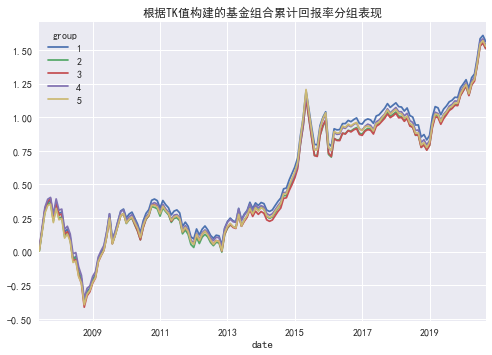

In [42]:
# 累计收益
group_return = data.groupby(['date', 'group'])['m_return'].mean().unstack(level='group')
fig = group_return.cumsum().plot()
plt.title('根据TK值构建的基金组合累计回报率分组表现')
plt.show()

3. Regression

In [181]:
data['next_m_return'] = data.groupby(['code'])['m_return'].shift(-1).values
data = data.dropna()

In [182]:
def basicRegression(y, X):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [186]:
y = data['m_return']
X = data[['m12_tk']]
results = basicRegression(y, X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               m_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     160.3
Date:                Wed, 12 May 2021   Prob (F-statistic):           1.07e-36
Time:                        20:44:32   Log-Likelihood:                 81981.
No. Observations:               68108   AIC:                        -1.640e+05
Df Residuals:                   68106   BIC:                        -1.639e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.082      0.037       0.000       0.004
m12_tk         0.8875      0.070     12.661      0.000       0.750       1.025
==============================================================================
Omnibus:                     4433.976   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17550.090
Skew:                          -0.216   Prob(JB):                         0.00
Kurtosis:                       5.449   Cond. No.                         252.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
y = data['m_return']
X = data[['m12_tk', 'age', 'asset']]
results = basicRegression(y, X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               m_return   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     122.4
Date:                Wed, 12 May 2021   Prob (F-statistic):           4.61e-79
Time:                        20:44:36   Log-Likelihood:                 82084.
No. Observations:               68108   AIC:                        -1.642e+05
Df Residuals:                   68104   BIC:                        -1.641e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.004      6.372      0.000       0.020       0.037
m12_tk         0.9437      0.070     13.452      0.000       0.806       1.081
age            0.0031      0.000      7.091      0.000       0.002       0.004
asset         -0.0025      0.000    -13.807      0.000      -0.003      -0.002
==============================================================================
Omnibus:                     4413.989   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17504.937
Skew:                          -0.212   Prob(JB):                         0.00
Kurtosis:                       5.447   Cond. No.                     5.54e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

4. netflow & TK

In [224]:
q_data = pd.read_csv('q_data.csv', index_col=False)
q_data['date'] = pd.to_datetime(q_data['date'])

In [225]:
q_data['last_netflow'] = q_data.groupby('code')['netflow'].shift().values

In [226]:
q_tk = month_data.groupby(['code', pd.Grouper(key='date', freq='Q')])['m_tk'].sum()
q_tk.name = 'q_tk'
age = month_data.groupby(['code', pd.Grouper(key='date', freq='Q')])['age'].last()
age.name = 'age'
add = pd.concat([q_tk, age], axis=1)

q_data = pd.merge(left=q_data, right=add, on=['code', 'date'], how='left')

In [227]:
q_data['asset'] = np.log(q_data['asset'] + 1)
q_data['netflow'] = np.log(q_data['netflow'] + 1)
q_data['last_netflow'] = np.log(q_data['last_netflow'] + 1)
q_data = q_data.dropna()

In [228]:
y = q_data['netflow']
X = q_data[['q_tk', 'age', 'asset', 'last_netflow', 'q_return']]
results = basicRegression(y, X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                netflow   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     1819.
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        20:56:11   Log-Likelihood:                -7086.7
No. Observations:                4433   AIC:                         1.419e+04
Df Residuals:                    4427   BIC:                         1.422e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5791      0.272     -2.132      0.033      -1.111      -0.047
q_tk            15.5926      1.520     10.261      0.000      12.613      18.572
age             -0.3102      0.023    -13.521      0.000      -0.355      -0.265
asset            0.9898      0.012     80.488      0.000       0.966       1.014
last_netflow    -0.0006      0.005     -0.123      0.902      -0.011       0.010
q_return         2.3573      0.168     13.993      0.000       2.027       2.688
==============================================================================
Omnibus:                      643.177   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1260.539
Skew:                          -0.898   Prob(JB):                    1.89e-274
Kurtosis:                       4.896   Cond. No.                     2.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""